In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
from glob import glob
import skimage.io as io
import shutil

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision as tv
import torch.nn.functional as F
from torch import Tensor
plt.close()

In [2]:
current_path = os.getcwd()
converted_path = current_path.replace('/', '\\')
print(converted_path)

\home\duong\git\DecodeItAll\bio_seman_seg\unet\sessile-main-Kvasir-SEG


In [3]:
bio_seg_dir = "/".join(converted_path.split("\\")[:-2])
print(bio_seg_dir)
print(os.path.exists(bio_seg_dir))

/home/duong/git/DecodeItAll/bio_seman_seg
True


In [4]:
data_dir = bio_seg_dir + "/dataset/sessile-main-Kvasir-SEG"
print(os.listdir(data_dir))

['masks', 'images']


In [5]:
img_dir = data_dir + "/images"
msk_dir = data_dir + "/masks"

print(f"No. Img: {len(os.listdir(img_dir))}")
print(f"No. Msk: {len(os.listdir(msk_dir))}")

No. Img: 196
No. Msk: 196


In [6]:
class PolypDataset(Dataset):
    def __init__(self, transform = None, target_transform = None):
        from glob import glob
        self.imgs = sorted(glob(img_dir + "/*"))
        self.msks = sorted(glob(msk_dir + "/*"))
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        msk_path = self.msks[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        if self.transform:
            img = self.transform(img)

        if self.target_transform:
            msk = self.target_transform(msk)

        return (img, msk)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


157


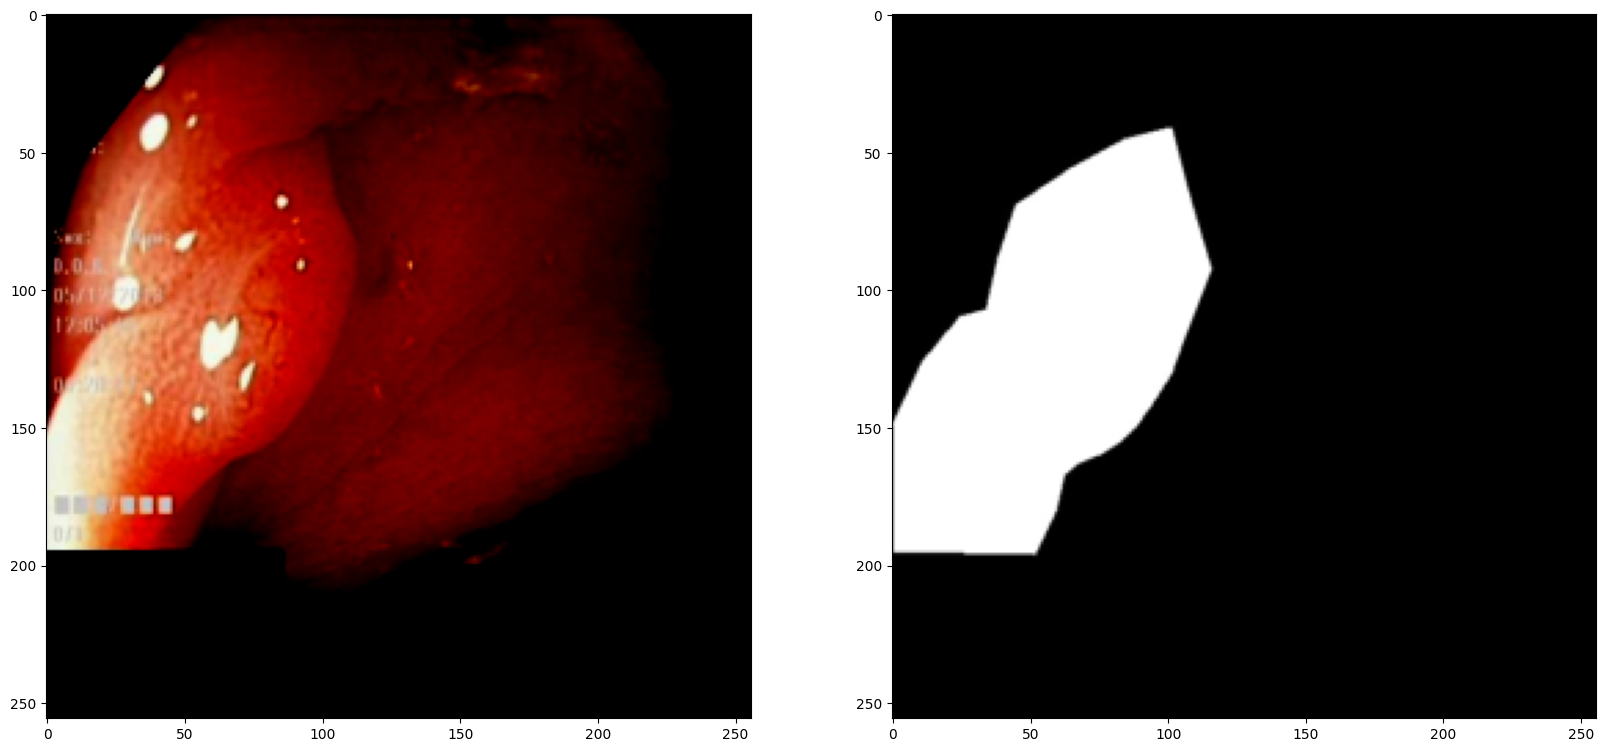

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

ds = PolypDataset(transform=transform, target_transform=target_transform)
train_ds, test_ds = random_split(ds, [0.8, 0.2])

print(len(train_ds))

img, msk = train_ds[35]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))

ax1.imshow(img.permute(1, -1, 0).numpy())
ax2.imshow(msk.permute(1, -1, 0).numpy(), cmap = 'gray')

In [8]:
train_dl = DataLoader(train_ds, batch_size=20, shuffle=True)

print(len(train_dl))

8


In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [10]:
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [11]:
class Up(nn.Module):    

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [12]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 16))
        self.down1 = (Down(16, 32)) #64, 128
        self.down2 = (Down(32, 64)) #128, 256
        self.down3 = (Down(64, 128)) #256, 512
        factor = 2 if bilinear else 1
        self.down4 = (Down(128, 256 // factor)) #512, 1024
        self.up1 = (Up(256, 128 // factor, bilinear)) #1024, 512
        self.up2 = (Up(128, 64 // factor, bilinear)) #512, 256
        self.up3 = (Up(64, 32 // factor, bilinear)) #256, 128
        self.up4 = (Up(32, 16, bilinear)) #128, 64
        self.outc = (OutConv(16, n_classes)) #64

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = UNet(3, 1, False).to(device)

optimizer = Adam(params = model.parameters(), lr = 0.001)

epochs = 100

loss_fn = nn.BCEWithLogitsLoss()

In [15]:
old_loss = 1e26
best_dct = None
last_dct = None
for epoch in range(epochs):
    model.train()
    tr_total_loss = 0
    tr_total_dice = 0
    tr_total_iou = 0
    for train_img, train_mask in tqdm(train_dl):
        train_img = train_img.to(device)
        train_mask = train_mask.to(device)

        train_gen_mask = model(train_img)        
        train_loss = loss_fn(train_gen_mask, train_mask)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()        
        
        tr_total_loss += train_loss.cpu().item()        
            
    mean_train_loss = tr_total_loss/len(train_dl)

    if mean_train_loss <= old_loss:
        old_loss = mean_train_loss
        best_dct = model.state_dict()
    
    last_dct = model.state_dict()

    print(f"Epoch: {epoch} - TrainLoss: {mean_train_loss}")
model.load_state_dict(best_dct)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.08it/s]


Epoch: 0 - TrainLoss: 0.6101225689053535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Epoch: 1 - TrainLoss: 0.5578310787677765


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.09it/s]


Epoch: 2 - TrainLoss: 0.5165448933839798


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Epoch: 3 - TrainLoss: 0.4778273403644562


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.74it/s]


Epoch: 4 - TrainLoss: 0.45143016055226326


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.06it/s]


Epoch: 5 - TrainLoss: 0.4322616197168827


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.88it/s]


Epoch: 6 - TrainLoss: 0.413442000746727


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.68it/s]


Epoch: 7 - TrainLoss: 0.4012316092848778


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Epoch: 8 - TrainLoss: 0.3900799788534641


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.62it/s]


Epoch: 9 - TrainLoss: 0.3748866617679596


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Epoch: 10 - TrainLoss: 0.3622157610952854


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.67it/s]


Epoch: 11 - TrainLoss: 0.3494962230324745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.83it/s]


Epoch: 12 - TrainLoss: 0.3407649025321007


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.72it/s]


Epoch: 13 - TrainLoss: 0.33050382137298584


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


Epoch: 14 - TrainLoss: 0.32044532522559166


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Epoch: 15 - TrainLoss: 0.31221309304237366


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Epoch: 16 - TrainLoss: 0.3037538677453995


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.08it/s]


Epoch: 17 - TrainLoss: 0.2958028055727482


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Epoch: 18 - TrainLoss: 0.288875974714756


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.01it/s]


Epoch: 19 - TrainLoss: 0.2822337467223406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.66it/s]


Epoch: 20 - TrainLoss: 0.2769329287111759


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch: 21 - TrainLoss: 0.2678989861160517


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.17it/s]


Epoch: 22 - TrainLoss: 0.2643542196601629


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.04it/s]


Epoch: 23 - TrainLoss: 0.2590461429208517


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.01it/s]


Epoch: 24 - TrainLoss: 0.2543049715459347


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Epoch: 25 - TrainLoss: 0.2469589300453663


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


Epoch: 26 - TrainLoss: 0.24409580416977406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.09it/s]


Epoch: 27 - TrainLoss: 0.23916389606893063


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch: 28 - TrainLoss: 0.2365025021135807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch: 29 - TrainLoss: 0.237021092325449


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.11it/s]


Epoch: 30 - TrainLoss: 0.23317123763263226


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.92it/s]


Epoch: 31 - TrainLoss: 0.22859621979296207


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.66it/s]


Epoch: 32 - TrainLoss: 0.2256630789488554


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.06it/s]


Epoch: 33 - TrainLoss: 0.2332759816199541


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.96it/s]


Epoch: 34 - TrainLoss: 0.22739992290735245


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.91it/s]


Epoch: 35 - TrainLoss: 0.2212151139974594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.12it/s]


Epoch: 36 - TrainLoss: 0.2221532892435789


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.73it/s]


Epoch: 37 - TrainLoss: 0.2166337501257658


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Epoch: 38 - TrainLoss: 0.21198014169931412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


Epoch: 39 - TrainLoss: 0.20898867212235928


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Epoch: 40 - TrainLoss: 0.2036619409918785


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.23it/s]


Epoch: 41 - TrainLoss: 0.20656617358326912


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Epoch: 42 - TrainLoss: 0.20634316839277744


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.93it/s]


Epoch: 43 - TrainLoss: 0.2018953189253807


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch: 44 - TrainLoss: 0.19612237997353077


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.72it/s]


Epoch: 45 - TrainLoss: 0.19403723999857903


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Epoch: 46 - TrainLoss: 0.19203167222440243


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]


Epoch: 47 - TrainLoss: 0.19580017402768135


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch: 48 - TrainLoss: 0.194146990776062


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch: 49 - TrainLoss: 0.1973198652267456


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.97it/s]


Epoch: 50 - TrainLoss: 0.1901014056056738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Epoch: 51 - TrainLoss: 0.18685671500861645


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Epoch: 52 - TrainLoss: 0.1849640104919672


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.68it/s]


Epoch: 53 - TrainLoss: 0.19001430459320545


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch: 54 - TrainLoss: 0.18476616777479649


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.97it/s]


Epoch: 55 - TrainLoss: 0.1794914696365595


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.22it/s]


Epoch: 56 - TrainLoss: 0.17812146991491318


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Epoch: 57 - TrainLoss: 0.1742023266851902


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Epoch: 58 - TrainLoss: 0.17329215444624424


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


Epoch: 59 - TrainLoss: 0.17356022540479898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Epoch: 60 - TrainLoss: 0.1671318430453539


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Epoch: 61 - TrainLoss: 0.16857986990362406


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.90it/s]


Epoch: 62 - TrainLoss: 0.16390845831483603


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


Epoch: 63 - TrainLoss: 0.16181775368750095


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.87it/s]


Epoch: 64 - TrainLoss: 0.16478211246430874


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.91it/s]


Epoch: 65 - TrainLoss: 0.16246473044157028


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.58it/s]


Epoch: 66 - TrainLoss: 0.15917606372386217


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Epoch: 67 - TrainLoss: 0.16081151366233826


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch: 68 - TrainLoss: 0.15552164986729622


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.77it/s]


Epoch: 69 - TrainLoss: 0.15170373767614365


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Epoch: 70 - TrainLoss: 0.1569142658263445


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.78it/s]


Epoch: 71 - TrainLoss: 0.14975364040583372


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.61it/s]


Epoch: 72 - TrainLoss: 0.1416640793904662


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Epoch: 73 - TrainLoss: 0.1338116331025958


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Epoch: 74 - TrainLoss: 0.1342204101383686


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.69it/s]


Epoch: 75 - TrainLoss: 0.13021875731647015


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.89it/s]


Epoch: 76 - TrainLoss: 0.1268265238031745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Epoch: 77 - TrainLoss: 0.12094336096197367


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.79it/s]


Epoch: 78 - TrainLoss: 0.12520392425358295


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.64it/s]


Epoch: 79 - TrainLoss: 0.12750039156526327


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch: 80 - TrainLoss: 0.11776307132095098


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Epoch: 81 - TrainLoss: 0.11900923307985067


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.71it/s]


Epoch: 82 - TrainLoss: 0.11189157515764236


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.77it/s]


Epoch: 83 - TrainLoss: 0.10472987964749336


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Epoch: 84 - TrainLoss: 0.10371489450335503


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.65it/s]


Epoch: 85 - TrainLoss: 0.09666317701339722


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.60it/s]


Epoch: 86 - TrainLoss: 0.09472016151994467


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.55it/s]


Epoch: 87 - TrainLoss: 0.09296293836086988


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Epoch: 88 - TrainLoss: 0.08790506888180971


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch: 89 - TrainLoss: 0.08998778369277716


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.08it/s]


Epoch: 90 - TrainLoss: 0.09160544723272324


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Epoch: 91 - TrainLoss: 0.09528354555368423


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.59it/s]


Epoch: 92 - TrainLoss: 0.09479625057429075


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.09it/s]


Epoch: 93 - TrainLoss: 0.08578172605484724


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.54it/s]


Epoch: 94 - TrainLoss: 0.08607007097452879


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.60it/s]


Epoch: 95 - TrainLoss: 0.08523908443748951


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.03it/s]


Epoch: 96 - TrainLoss: 0.08697630185633898


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.76it/s]


Epoch: 97 - TrainLoss: 0.0761792128905654


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.78it/s]


Epoch: 98 - TrainLoss: 0.0687677338719368


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.10it/s]

Epoch: 99 - TrainLoss: 0.06234847102314234


<All keys matched successfully>

In [17]:
test_dl = DataLoader(test_ds, batch_size=1, shuffle=True)
print(len(test_dl))

39


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


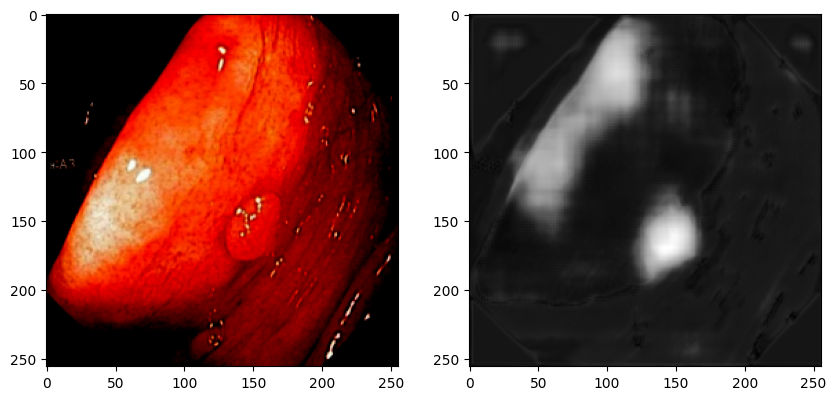

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


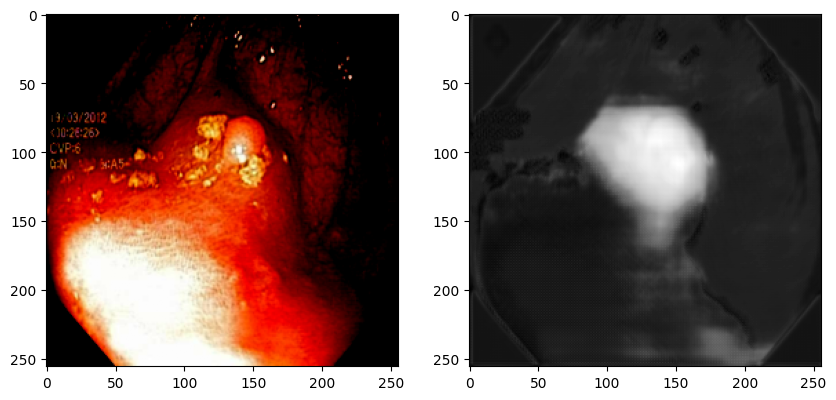

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


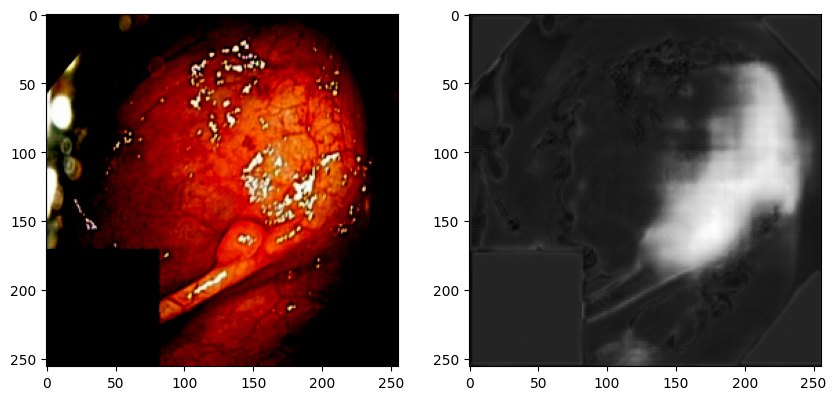

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


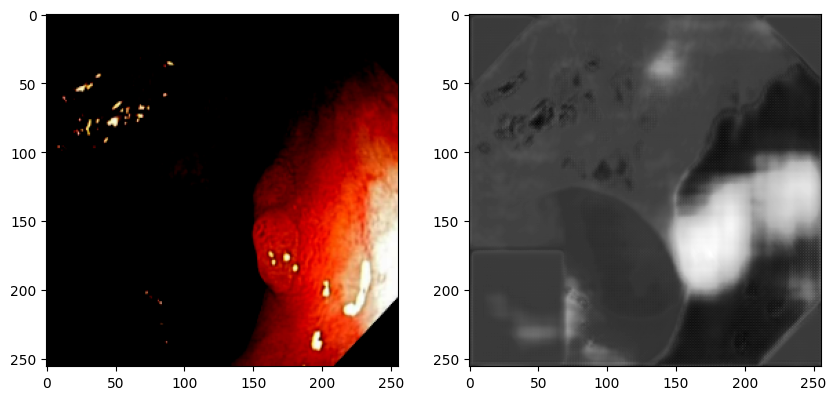

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


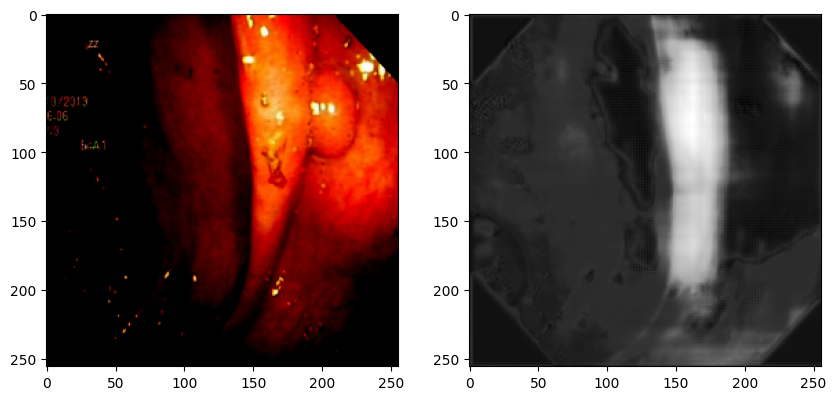

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


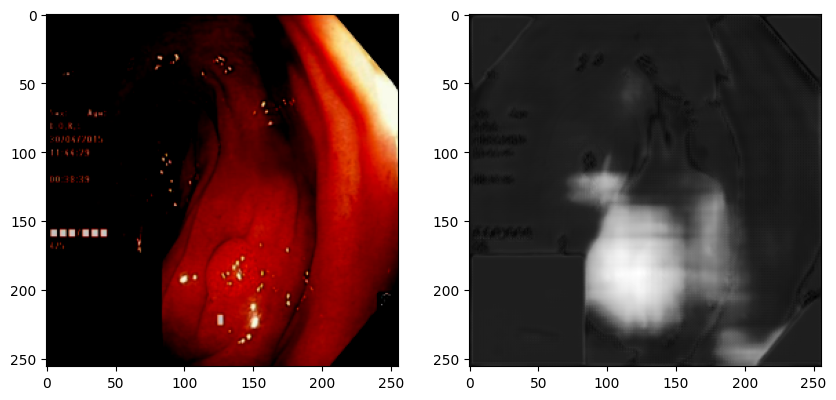

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


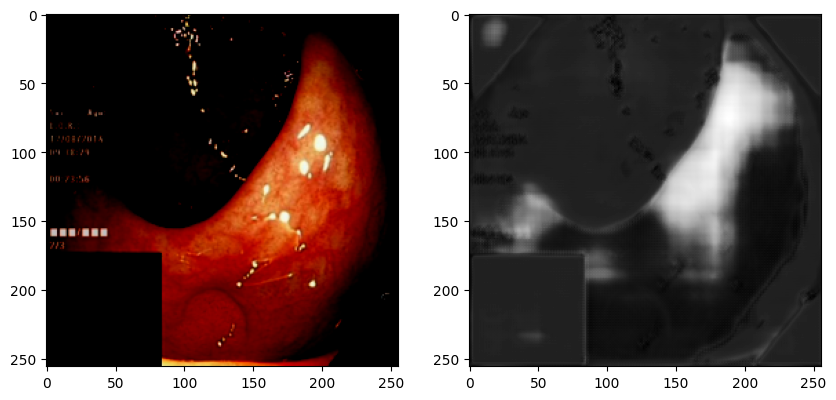

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


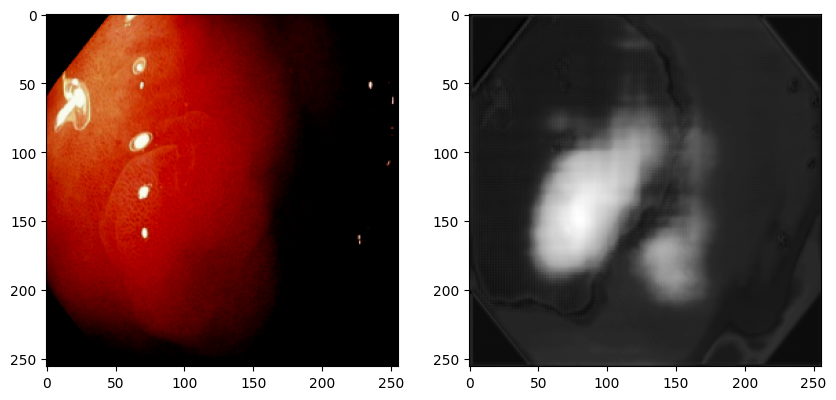

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


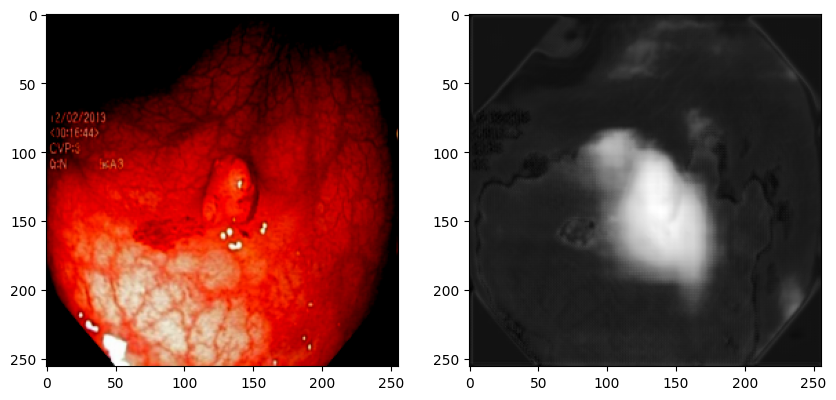

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


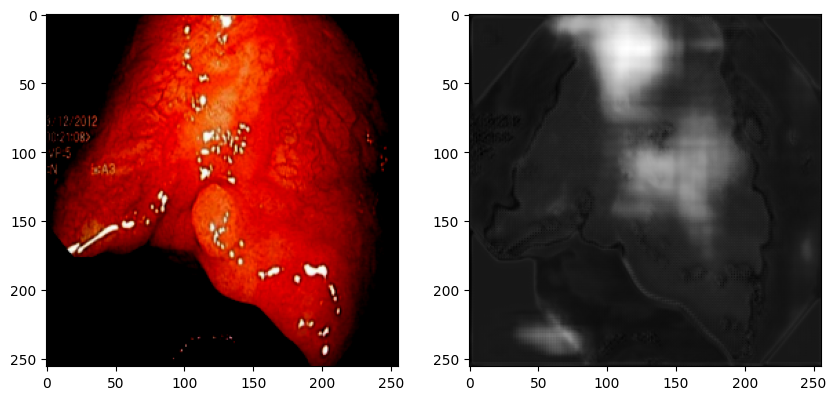

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


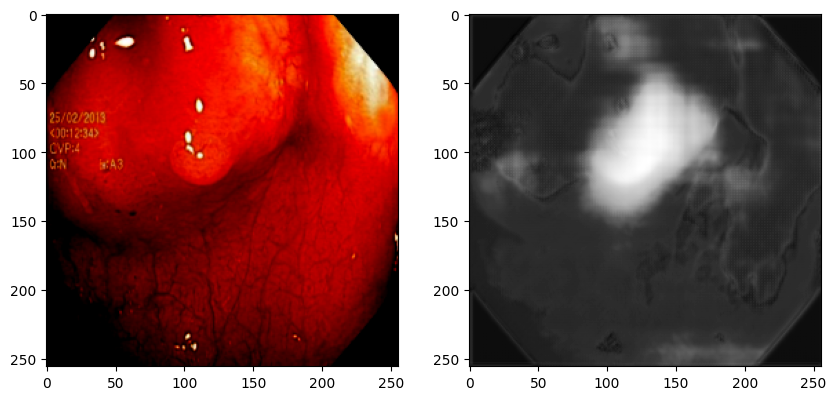

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


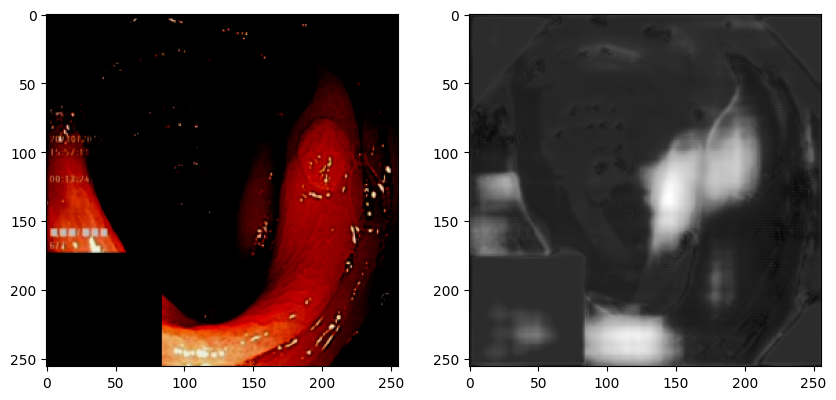

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


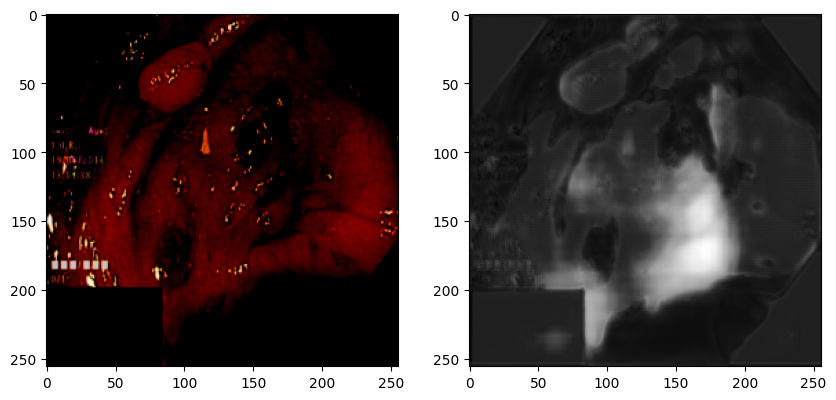

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


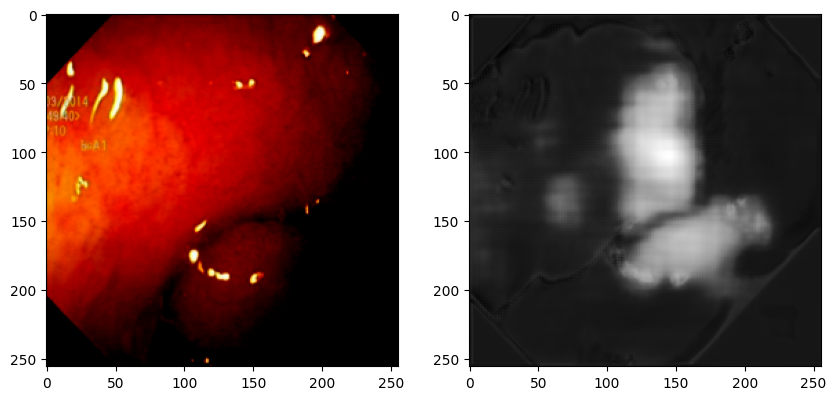

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


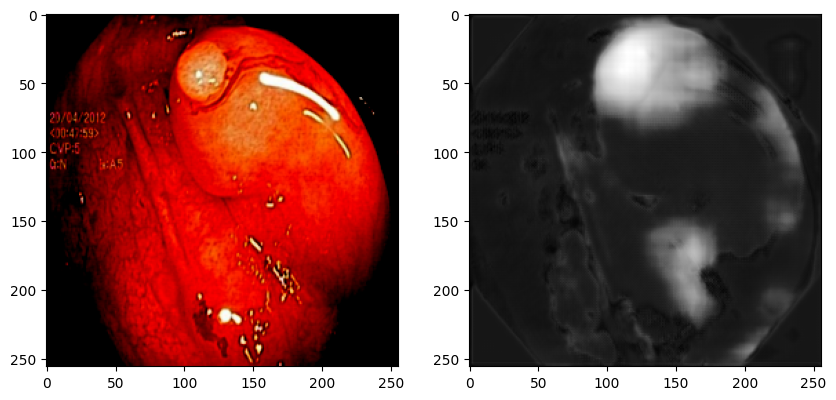

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


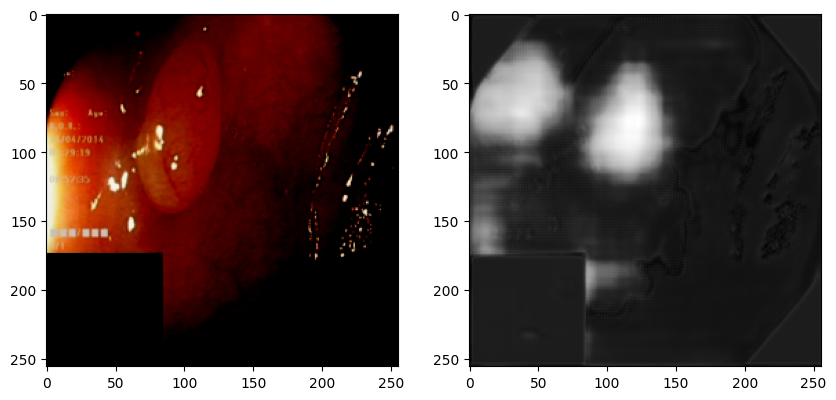

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


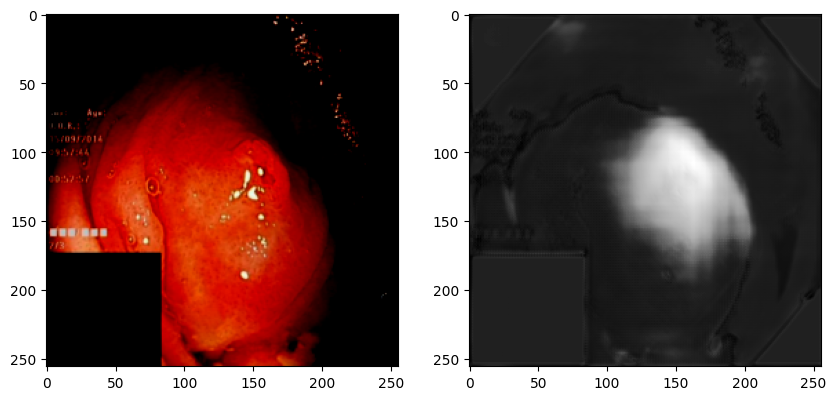

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


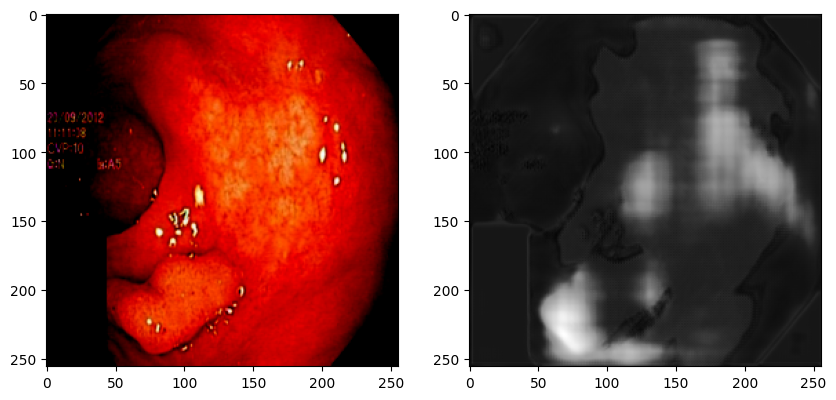

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


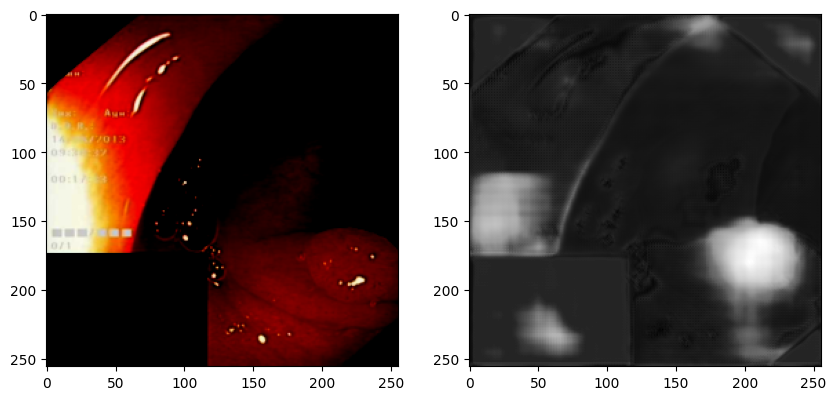

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


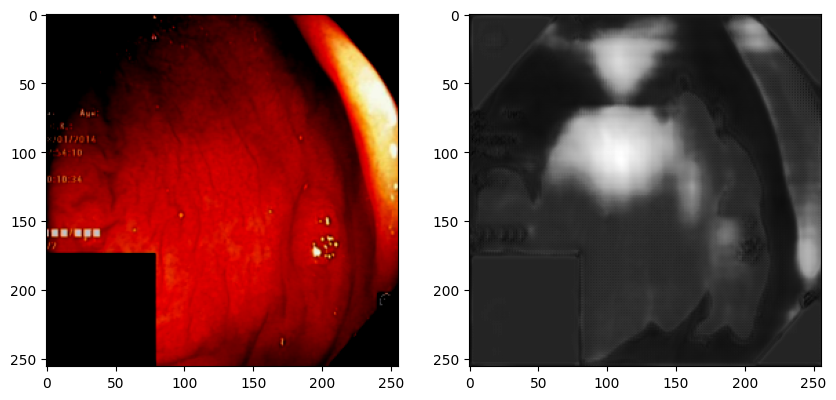

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


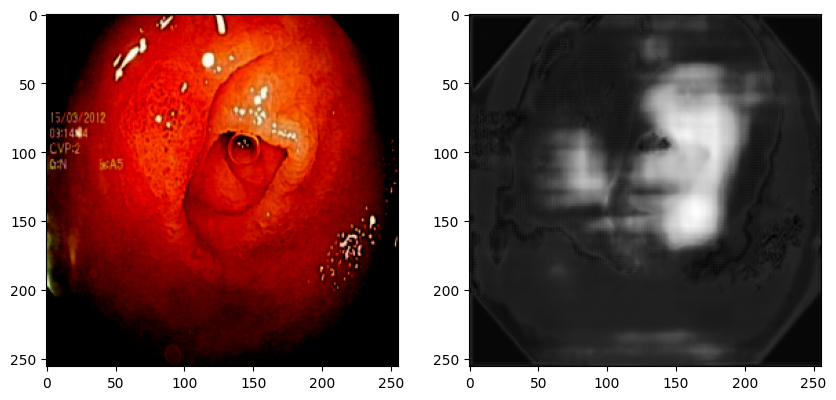

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


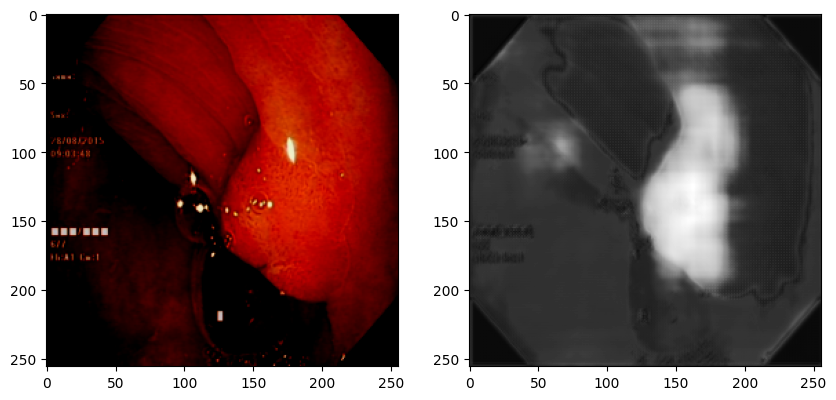

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


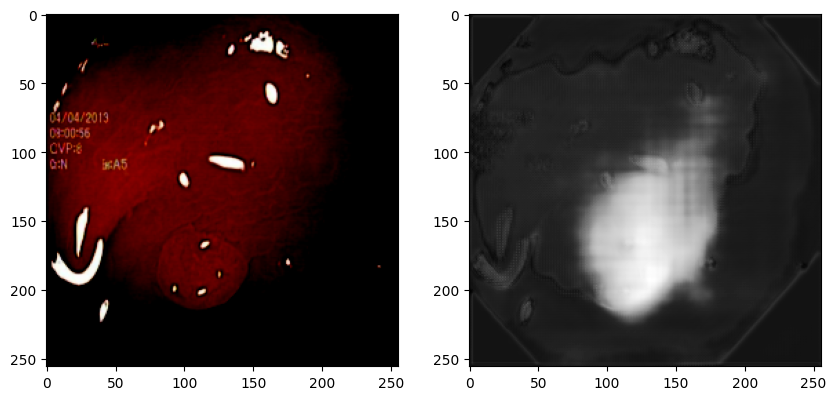

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


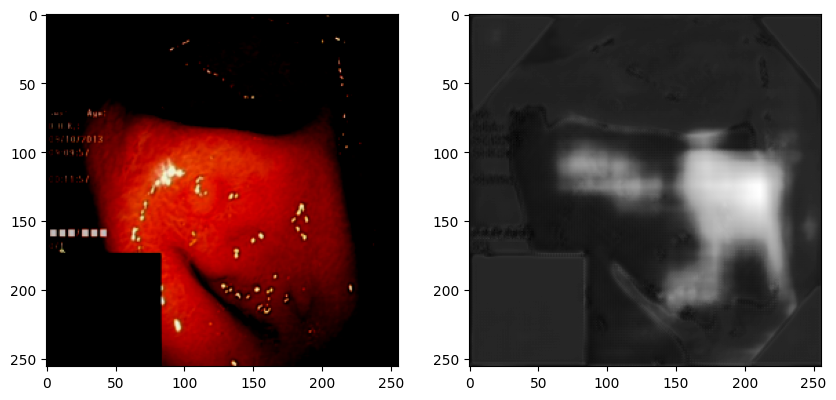

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


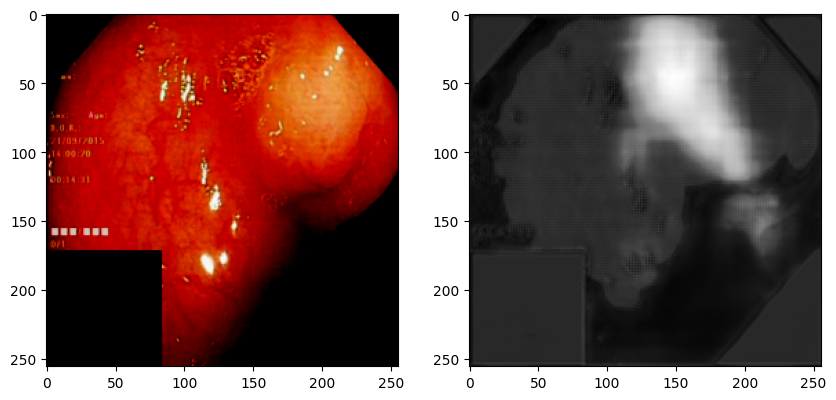

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


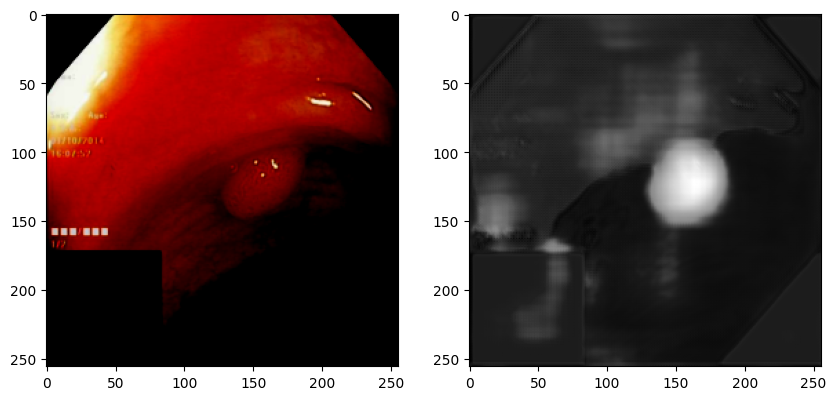

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


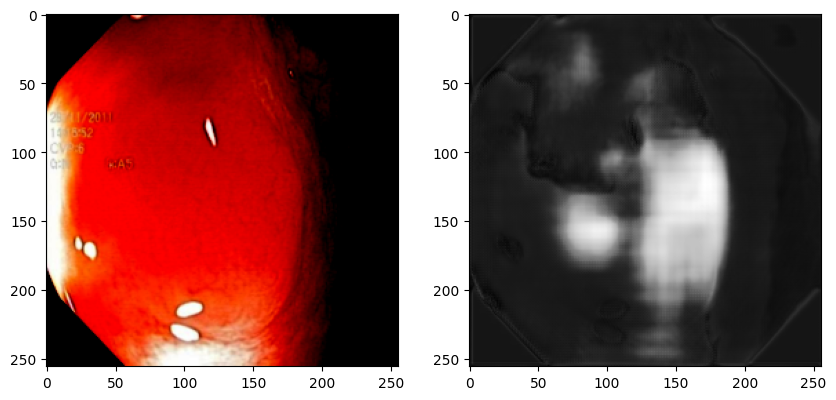

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


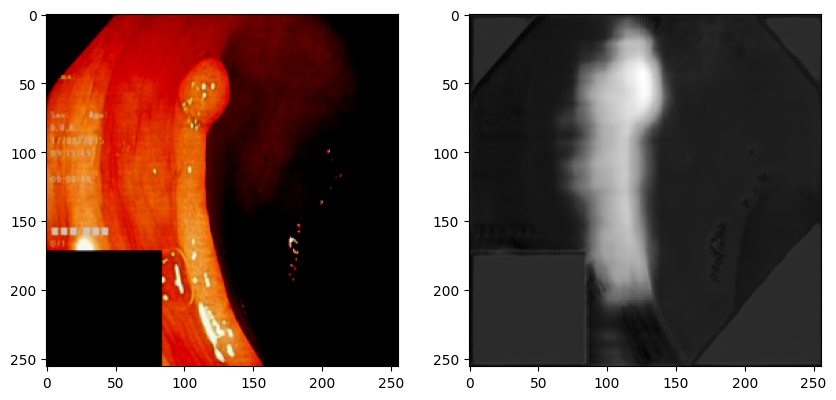

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


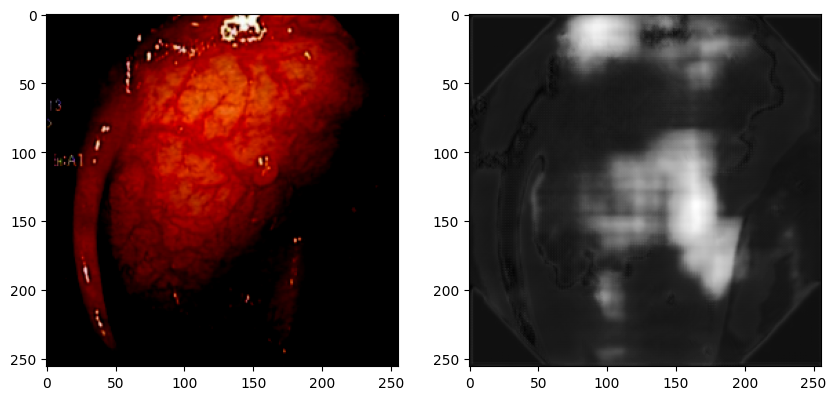

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


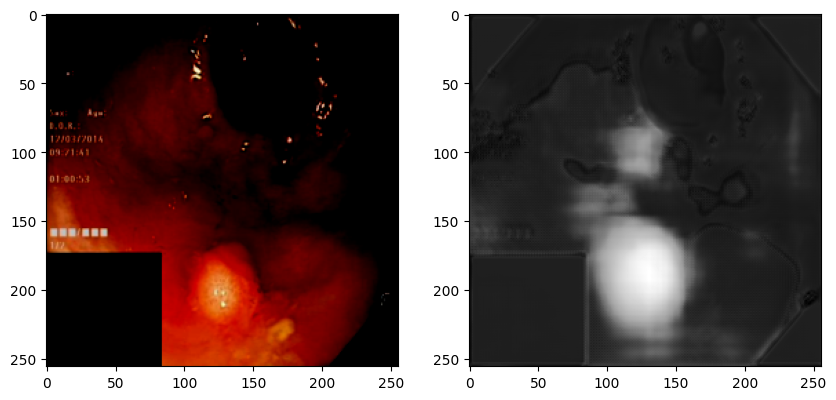

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


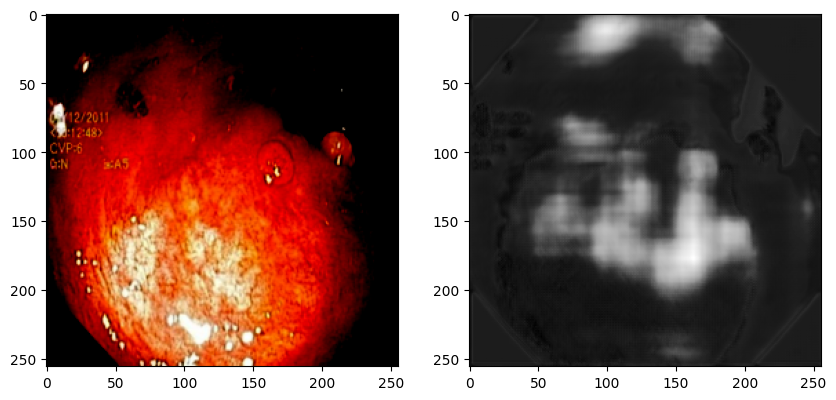

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


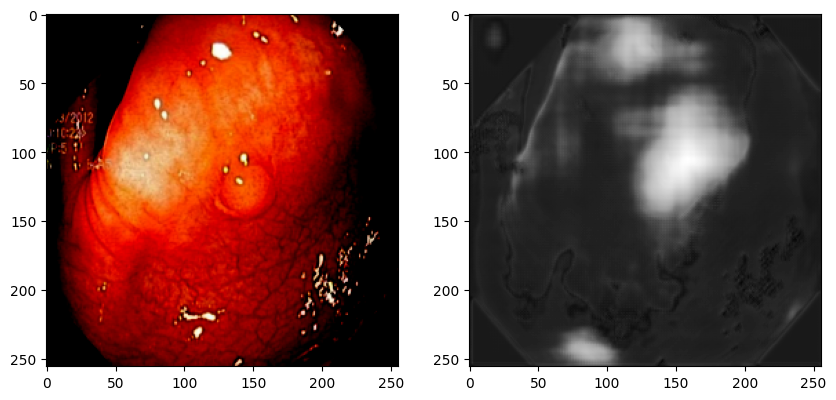

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


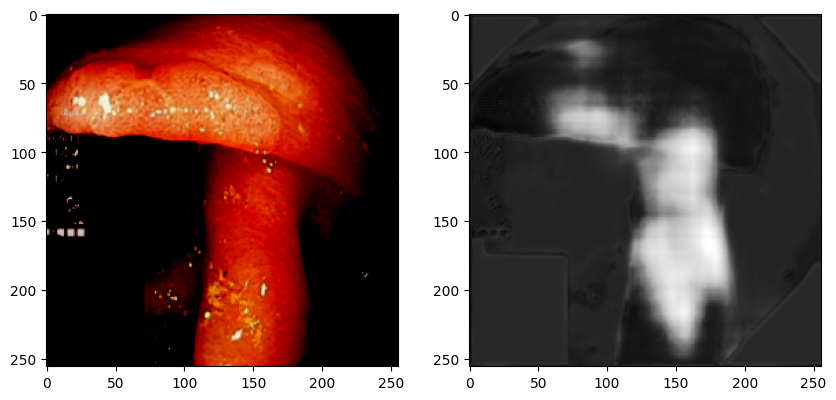

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


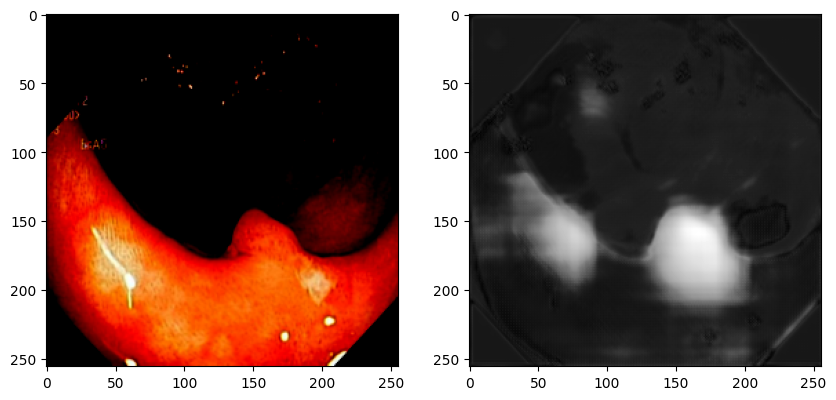

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


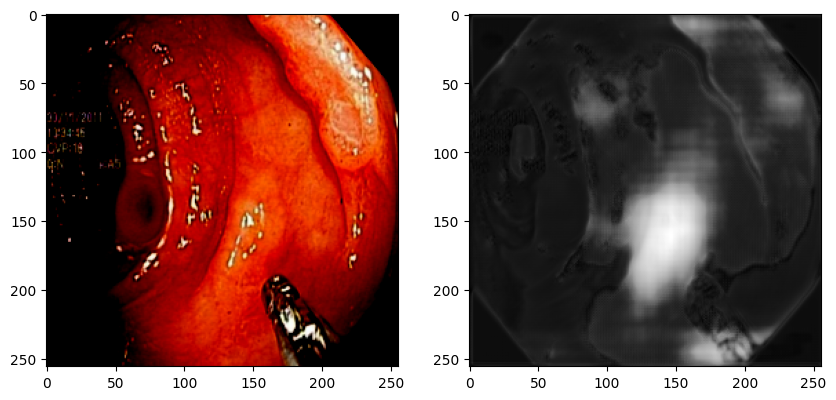

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


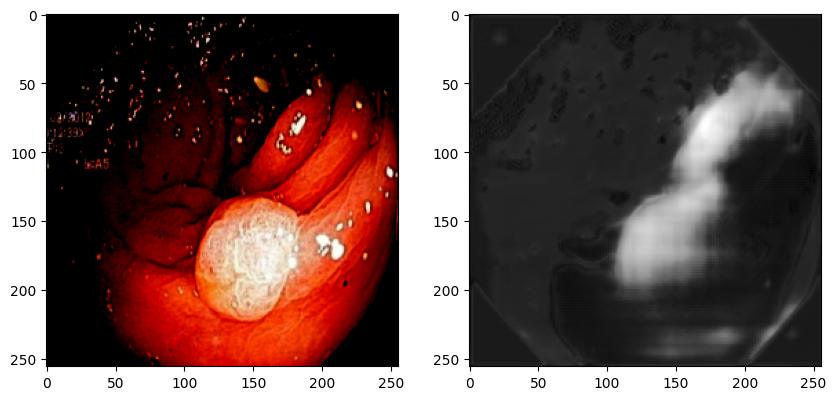

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


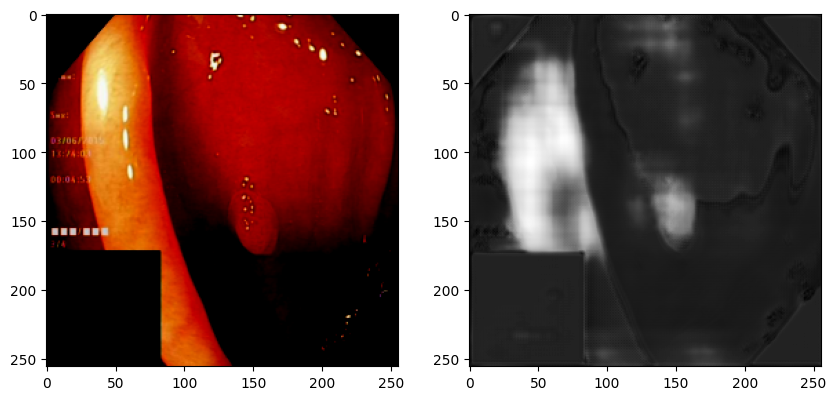

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


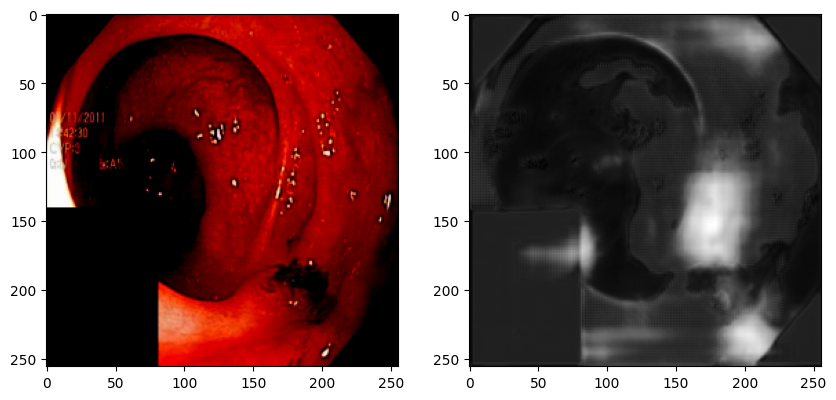

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


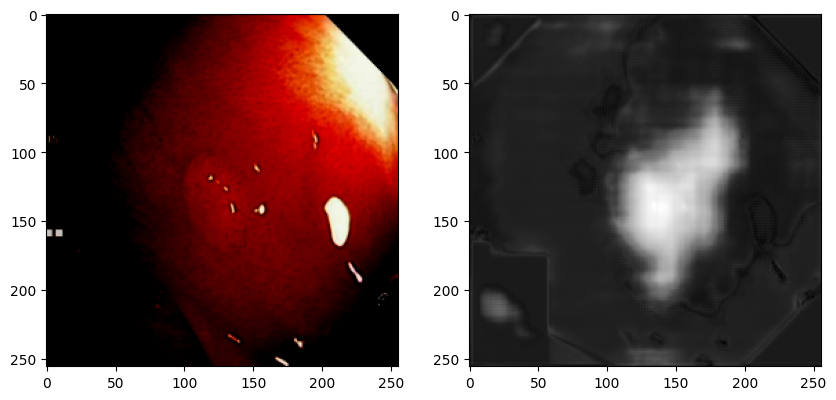

In [18]:
from glob import glob
for img, _ in test_dl:
    img = img.to(device)

    mask = model(img)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

    ax1.imshow(img[0].permute(1, -1, 0).detach().cpu().numpy())
    ax2.imshow(mask[0].permute(1, -1, 0).detach().cpu().numpy(), cmap = 'gray')

    plt.show()  
    plt.close("all")  